# Treinamento de Modelo: Regressão Logística
> **Fase 3 - Time 7**

**Responsável:** Fernanda Neves;
**Algoritmo:** Regressão Logística

**Objetivos deste Notebook:**
1.  **Carregar:** Importar os dados de treino/teste padronizados (do pré-processamento unificado).
2.  **Treinar:** Ajustar o modelo **Regressão Logística** aos dados de treino.
3.  **Avaliar:** Medir a performance com foco no **Recall** (Sensibilidade) para detectar doenças.
4.  **Validar:** Testar se o modelo consegue identificar o grupo de risco "Assintomático".

**Métricas Chave:**
* **Recall (Sensibilidade):** Prioridade máxima. Não podemos deixar doentes irem para casa.
* **F1-Score:** Para garantir que não estamos apenas "chutando que todos estão doentes".

## 1. Configuração de ambiente
Importação de bibliotecas e definição de estilos gráficos padronizados.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import json

# Métricas padronizadas
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Configuração visual
sns.set_theme(style="whitegrid")
palette = sns.color_palette("coolwarm", as_cmap=True)

In [11]:
# Carregamento dos Dados Processados (Pasta data/processed)
# IMPORTANTE: Não mexer neste bloco para garantir compatibilidade!

try:
    X_train = joblib.load('../data/processed/X_train.pkl')
    y_train = joblib.load('../data/processed/y_train.pkl')
    X_test = joblib.load('../data/processed/X_test.pkl')
    y_test = joblib.load('../data/processed/y_test.pkl')
    feature_names = joblib.load('../data/processed/feature_names.pkl')
    
    print(f"Dados carregados com sucesso!")
    print(f"Treino: {X_train.shape}")
    print(f"Teste:  {X_test.shape}")
except FileNotFoundError:
    print("Arquivos não encontrados. Rode o notebook '02_preprocessing_unificado.ipynb' primeiro.")

Dados carregados com sucesso!
Treino: (237, 22)
Teste:  (60, 22)


## 2. Treinamento do Modelo

Adotaremos uma abordagem em duas etapas:
1.  **Baseline:** Treinar o modelo com parâmetros padrão (default) para estabelecer uma linha de base.
2.  **Otimização:** Encontrar a melhor combinação de hiperparâmetros focada em **Recall**.

### 2.1 Baseline

In [12]:
# BASELINE (Modelo "Cru")

# 1. Importe seu modelo - Regressão Logística
from sklearn.linear_model import LogisticRegression

# 2. Instancie com parâmetros padrão
model_baseline = LogisticRegression(random_state=42, max_iter=1000)

print("Treinando Baseline - Regressão Logística...")
model_baseline.fit(X_train, y_train)

# Avaliação Rápida do Baseline
y_pred_base = model_baseline.predict(X_test)
recall_base = recall_score(y_test, y_pred_base)
print(f"Baseline treinado! Recall inicial: {recall_base:.2%}")

Treinando Baseline - Regressão Logística...
Baseline treinado! Recall inicial: 78.57%


### 2.2 Otimização

In [13]:
# OTIMIZAÇÃO DE HIPERPARÂMETROS COM GRIDSEARCHCV
from sklearn.model_selection import GridSearchCV

# A. Defina o Grid de Parâmetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],            # Força da regularização
    'solver': ['liblinear', 'saga'],         # Algoritmos de otimização
    'penalty': ['l1', 'l2'],                 # Tipo de regularização
}

# B. Configuração da Busca
# scoring='recall': Dizemos ao GridSearch que o mais importante é ACERTAR OS DOENTES
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_grid=param_grid,
    cv=5,               # Validação Cruzada em 5 partes
    scoring='recall',   # Foco total em Recall
    n_jobs=-1,          # Usa todos os processadores
    verbose=1
)

print("Iniciando busca pelos melhores parâmetros (pode demorar)...")
grid_search.fit(X_train, y_train)

# C. Melhores Resultados
best_model = grid_search.best_estimator_

print("-" * 30)
print(f"Melhor Recall na Validação: {grid_search.best_score_:.2%}")
print(f"Melhores Parâmetros: {grid_search.best_params_}")

Iniciando busca pelos melhores parâmetros (pode demorar)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
------------------------------
Melhor Recall na Validação: 78.05%
Melhores Parâmetros: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/fmn/cc/ligia-ps26-time7/venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home

## 3. Avaliação de Performance

📈 Evolução do Recall:
   - Baseline:  78.57%
   - Otimizado: 78.57%
   - Ganho:     0.00%


<Figure size 600x500 with 0 Axes>

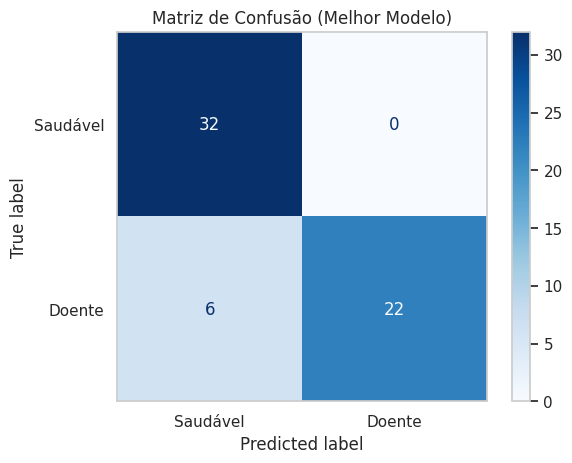

              precision    recall  f1-score   support

           0       0.84      1.00      0.91        32
           1       1.00      0.79      0.88        28

    accuracy                           0.90        60
   macro avg       0.92      0.89      0.90        60
weighted avg       0.92      0.90      0.90        60



In [14]:
# Previsões do Melhor Modelo
y_pred_final = best_model.predict(X_test)
recall_final = recall_score(y_test, y_pred_final)

print(f"📈 Evolução do Recall:")
print(f"   - Baseline:  {recall_base:.2%}")
print(f"   - Otimizado: {recall_final:.2%}")
print(f"   - Ganho:     {(recall_final - recall_base):.2%}")

# Matriz de Confusão do Modelo Campeão
plt.figure(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_final, cmap='Blues', display_labels=['Saudável', 'Doente'])
plt.title('Matriz de Confusão (Melhor Modelo)')
plt.grid(False)
plt.show()

# Classification Report Completo
print(classification_report(y_test, y_pred_final))

### 3.1. Avalição de Grupo Assintomático
Nesta etapa, validaremos a tese central: Verificaremos a performance do modelo especificamente nos pacientes que **não apresentavam dor típica** (CP=3: Asymptomatic).

> **Por que isso é importante?**
> A maioria dos erros humanos acontece aqui. Se nosso modelo tiver um bom Recall neste grupo, provamos que a IA enxerga além do óbvio.

In [15]:
# VALIDAÇÃO NO SUBGRUPO ASSINTOMÁTICO

# 1. Identificando a coluna correta (pós One-Hot Encoding)
# O nome da coluna geralmente é 'cp_3.0' ou 'cp_3', dependendo do processamento
cols_assintomaticas = [col for col in X_test.columns if 'cp_3' in col]

if len(cols_assintomaticas) > 0:
    col_alvo = cols_assintomaticas[0]
    print(f"Analisando subgrupo oculto: '{col_alvo}'")

    # 2. Filtrando os dados
    # Pegamos apenas as linhas onde o paciente é assintomático (Valor 1 na coluna)
    mask_assin = X_test[col_alvo] == 1
    
    X_test_sub = X_test[mask_assin]
    y_test_sub = y_test[mask_assin.values]

    if len(X_test_sub) > 0:
        # 3. Avaliando o Melhor Modelo neste subgrupo
        y_pred_sub = best_model.predict(X_test_sub)
        
        recall_sub = recall_score(y_test_sub, y_pred_sub)
        acc_sub = sum(y_test_sub == y_pred_sub) / len(y_test_sub)
        
        print("-" * 40)
        print(f"RESULTADO DO TESTE DE FOGO:")
        print(f"   Pacientes Assintomáticos no Teste: {len(X_test_sub)}")
        print(f"   Recall (Doentes detectados): {recall_sub:.2%}")
        print("-" * 40)
        
        if recall_sub > 0.80:
            print("✅ SUCESSO: O modelo é excelente em detectar isquemia silenciosa!")
        else:
            print("⚠️ ATENÇÃO: O modelo tem dificuldade com casos sem dor. Considere ajustar o threshold.")
    else:
        print("Nenhum paciente assintomático caiu na amostragem de teste atual.")
else:
    print("Coluna de 'cp_3' não encontrada. Verifique os nomes das features.")

Analisando subgrupo oculto: 'cp_3'
----------------------------------------
RESULTADO DO TESTE DE FOGO:
   Pacientes Assintomáticos no Teste: 31
   Recall (Doentes detectados): 86.36%
----------------------------------------
✅ SUCESSO: O modelo é excelente em detectar isquemia silenciosa!


## 4. Exportação do Modelo
Salvando o modelo campeão (otimizado) para uso na aplicação final.

In [16]:
# Exportação do Modelo
os.makedirs('../models', exist_ok=True)

# 1. Definindo um nome
nome_arquivo = 'modelo_RegressaoLogistica_Otimizado.pkl'
caminho_final = f'../models/{nome_arquivo}'

# 2. Salva o Modelo
joblib.dump(best_model, caminho_final)

# 3. Salva o "Segredo" (Metadata)
metadata = {
    "algoritmo": best_model.__class__.__name__,
}

with open('../models/metadata_RegressaoLogistica.json', 'w') as f:
    json.dump(metadata, f)

print(f"💾 Modelo salvo em: {caminho_final}")

💾 Modelo salvo em: ../models/modelo_RegressaoLogistica_Otimizado.pkl
